# Calibrating Traditional Methods

In this notebook, we show how to calibrate a $\mathcal{J}$-invariant denoiser, and compare its performance
with the original denoiser.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise

In [4]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_mse as mse
from util import plot_grid, plot_images, expand

In [5]:
plt.rc('figure', figsize = (5,5))

In [6]:
show = lambda x: plt.imshow(x, cmap=plt.cm.gray)

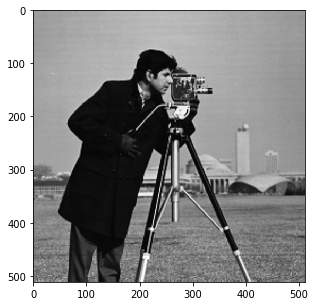

In [7]:
image = data.camera()
show(image)

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


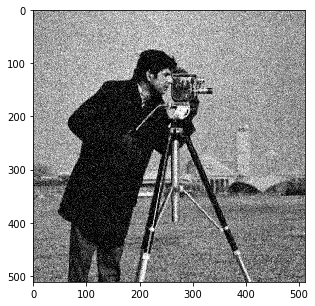

In [8]:
np.random.seed(3)
noisy_image = img_as_ubyte(random_noise(image, mode = 'gaussian', var=0.01))
show(noisy_image)

We begin by comparing an ordinary median filter to a "donut" median filter, with the center removed.

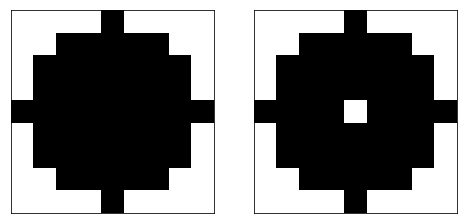

In [9]:
def mask_center(x):
    x[len(x)//2,len(x)//2] = 0
    return x
plot_images([1-disk(4), 1-mask_center(disk(4))])

In [10]:
radii = range(1, 7)
mask_med = np.array([median(noisy_image, mask_center(disk(i))) for i in radii])
med = np.array([median(noisy_image, disk(i)) for i in radii])

In [11]:
def stats(im_list, noisy_img, img):
    img = img_as_float(img)
    noisy_img = img_as_float(noisy_img)
    im_list = [img_as_float(x) for x in im_list]
    
    loss = [mse(x, noisy_img) for x in im_list]
    mse_gt = [mse(x, img) for x in im_list]
    psnr_gt = [psnr(x, img) for x in im_list]
    
    return loss, mse_gt, psnr_gt

In [12]:
loss_med, mse_med, psnr_med = stats(med, noisy_image, image)
loss_mask_med, mse_mask_med, psnr_mask_med = stats(mask_med, noisy_image, image)
opt = radii[np.argmin(loss_mask_med)]

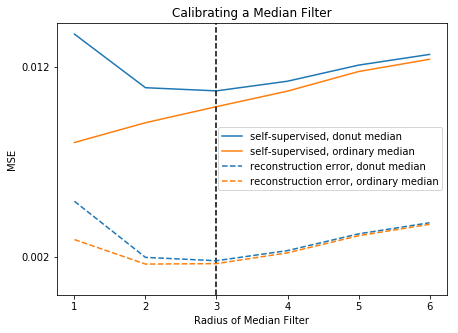

In [13]:
plt.figure(figsize=(7,5))

plt.plot(radii, loss_mask_med, label = 'self-supervised, donut median', color = 'C0')
plt.plot(radii, loss_med, label = 'self-supervised, ordinary median', color = 'C1')

plt.axvline(radii[np.argmin(loss_mask_med)], color='k', linestyle='--')
plt.title('Calibrating a Median Filter')

plt.plot(radii, mse_mask_med, label = 'reconstruction error, donut median', color = 'C0', linestyle='--')
plt.plot(radii, mse_med, label = 'reconstruction error, ordinary median', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Radius of Median Filter')

plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)
plt.legend(loc='center right')

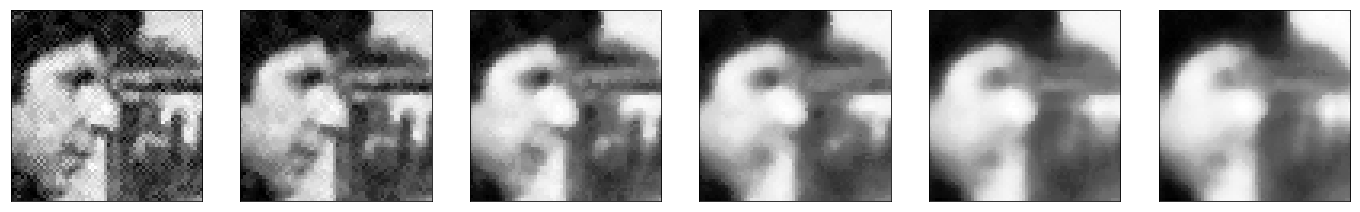

In [14]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]


plot_images([get_inset(mask_med[i]) for i in range(len(radii))])

The third image, at radius 3, is has the best PSNR.

# Conversion to J-invariance

Let $f$ be a classical denoiser, and consider some partition $\mathcal{J}$ of the pixels. Let $s(x)$ be the 
function replacing each pixel with the average of its neighbors. Then the function $g$ defined by

$g(x)_J := f_\theta(\mathbf{1}_{J}\cdot s(x) + \mathbf{1}_{J^c}\cdot x)_J,$

will be $J$-invariant for each $J \in \mathcal{J}$.

Below, we implement this in a functional way: given a denoiser, the `invariant_denoise` is the appropriate invariant denoiser.

In [15]:
from scipy.signal import convolve2d
def interpolate_image(x, conv_filter=None):
    if conv_filter is None:
        conv_filter = np.array([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])
    return convolve2d(x, conv_filter, mode = 'same')
def generate_mask(shape, idx, width=3):
    m = np.zeros(shape)
    
    phasex = idx % width
    phasey = (idx // width) % width
    
    m[phasex::width, phasey::width] = 1
    return m
def invariant_denoise(img, width, denoiser):
    
    n_masks = width*width
    
    interp = interpolate_image(img)
    
    output = np.zeros(img.shape)
    
    for i in range(n_masks):
        m = generate_mask(img.shape, i, width=width)
        input_image = m*interp + (1 - m)*img
        input_image = input_image.astype(img.dtype)
        output += m*denoiser(input_image)
    return output

## Wavelet

We now calibrate a wavelet filter, where we tune the threshold $\sigma$ used to threshold small wavelet coefficients.

In [16]:
from skimage.restoration import denoise_wavelet

In [17]:
sigma_range = np.arange(0.08, 0.3, 0.03)

In [18]:
reconstructions_wavelet = [denoise_wavelet(noisy_image, sigma = sigma, mode='hard', multichannel = False)
                   for sigma in sigma_range]

In [19]:
invariant_reconstructions_wavelet = [invariant_denoise(noisy_image, 4, lambda x: 
                                    denoise_wavelet(x, sigma = sigma, mode='hard', multichannel = False))
                   for sigma in sigma_range]

In [20]:
loss_wavelet, mse_wavelet, psnr_wavelet = stats(reconstructions_wavelet, noisy_image, image)
loss_mask_wavelet, mse_mask_wavelet, psnr_mask_wavelet = stats(invariant_reconstructions_wavelet, noisy_image, image)

In [21]:
opt_idx = np.argmin(loss_mask_wavelet)
opt = sigma_range[opt_idx]
opt_idx, opt

(2, 0.14)

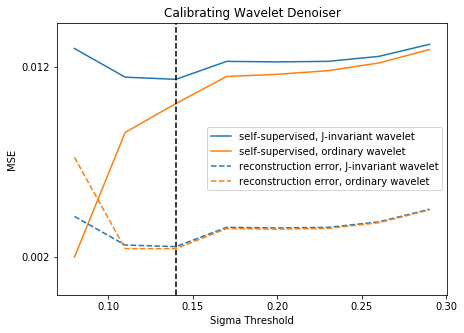

In [22]:
plt.figure(figsize=(7,5))

plt.plot(sigma_range, loss_mask_wavelet, label = 'self-supervised, J-invariant wavelet', color = 'C0')
plt.plot(sigma_range, loss_wavelet, label = 'self-supervised, ordinary wavelet', color = 'C1')

plt.axvline(sigma_range[np.argmin(loss_mask_wavelet)], color='k', linestyle='--')
plt.title('Calibrating Wavelet Denoiser')

plt.plot(sigma_range, mse_mask_wavelet, label = 'reconstruction error, J-invariant wavelet', color = 'C0', linestyle='--')
plt.plot(sigma_range, mse_wavelet, label = 'reconstruction error, ordinary wavelet', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Sigma Threshold')
plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)

plt.legend(loc='center right')

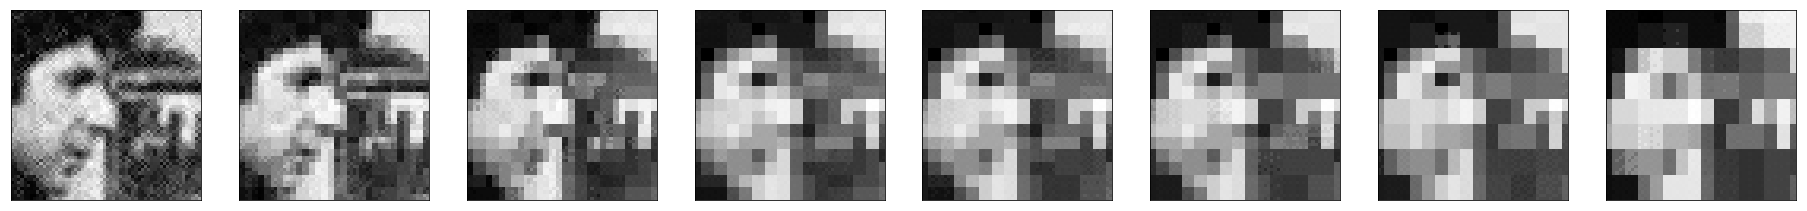

In [23]:
plot_images([get_inset(invariant_reconstructions_wavelet[i]) for i in range(len(sigma_range))])

The second image, at sigma=0.14, has the best PSNR.

## NL-Means

We now calibrate NL-means, where we tune the cut-off distance $h$ used to select nearby patches.

In [24]:
from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

h_suggested = 0.8 * sigma_est

In [25]:
h_range = sigma_est*np.arange(0.5, 2.0, 0.2)

In [26]:
reconstructions_nl = [denoise_nl_means(noisy_image, h=h, fast_mode=True,
                                **patch_kw)/255 for h in h_range]

invariant_reconstructions_nl = [invariant_denoise(noisy_image, 4, lambda x: denoise_nl_means(x, h=h, fast_mode=True,
                                **patch_kw))/255 for h in h_range]

In [27]:
loss_nl, mse_nl, psnr_nl = stats(reconstructions_nl, noisy_image, image)
loss_mask_nl, mse_mask_nl, psnr_mask_nl = stats(invariant_reconstructions_nl, noisy_image, image)

In [28]:
opt_idx = np.argmin(loss_mask_nl)
opt = sigma_range[opt_idx]

(0, 0.0143)

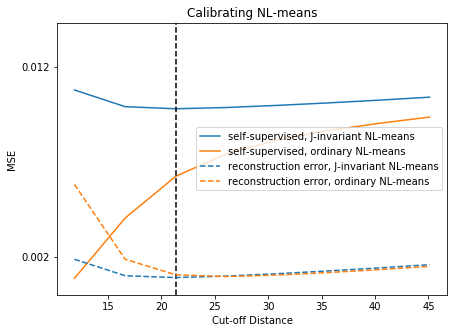

In [29]:
plt.figure(figsize=(7,5))

plt.plot(h_range, loss_mask_nl, label = 'self-supervised, J-invariant NL-means', color = 'C0')
plt.plot(h_range, loss_nl, label = 'self-supervised, ordinary NL-means', color = 'C1')

plt.axvline(h_range[np.argmin(loss_mask_nl)], color='k', linestyle='--')
plt.title('Calibrating NL-means')

plt.plot(h_range, mse_mask_nl, label = 'reconstruction error, J-invariant NL-means', color = 'C0', linestyle='--')
plt.plot(h_range, mse_nl, label = 'reconstruction error, ordinary NL-means', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Cut-off Distance')

plt.legend(loc='center right')
plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)

# Which method is best?

We may compare the self-supervised loss for the best denoiser in each class, and use that to identify the denoiser which will have the best reconstruction error/PSNR.

In [30]:
min(loss_mask_med).round(4), min(loss_mask_wavelet).round(4), min(loss_mask_nl).round(4) 

(0.0107, 0.0113, 0.0098)

In [31]:
max(psnr_mask_med).round(2), max(psnr_mask_wavelet).round(2), max(psnr_mask_nl).round(2)

(27.46, 25.96, 30.43)

NL-means wins.

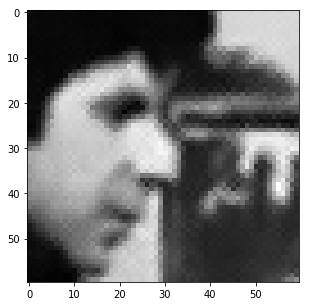

In [32]:
show(get_inset(invariant_reconstructions_nl[np.argmin(loss_mask_nl)]))

## Shrinkage

Given two uncorrelated and unbiased estimators $u$ and $v$ of some quantity $y$, we may form a linear combination:
    
$\lambda u + (1 - \lambda)v.$

The variance of this estimator is

$\lambda^2 U + (1 - \lambda)^2 V,$

where $U$ and $V$ are the variances of $u$ and $v$ respectively. This expression is minimized at

$\lambda = V/(U + V).$

We apply this to estimating $y$ from $x_j$ and the $\mathcal{J}$-invariant estimators we have learned above.

If we know the distribution of the noise, ie, we know the variance of $x_j|y_j$, then we can compute the variance of $y_j|x_{-j}$ by subtracting it from the variance of $x_j|x_{-j}$, aka, from the value of the loss. That will provide us with the optimal $\lambda$ to use.

This provide a mild improvement on top of the best $\mathcal{J}$-invariant estimator when we know the noise variance.

In [33]:
image_float = img_as_float(image)
noisy_image_float = img_as_float(noisy_image)

In [34]:
noise_var = mse(noisy_image_float, image_float)

In [35]:
idx = np.argmin(loss_mask_nl)
y_pred = invariant_reconstructions_nl[idx]
total_var = loss_mask_nl[idx]

lam = noise_var/total_var
improved_prediction = lam*y_pred + (1 - lam)*noisy_image_float
print("Lambda weighting: ", np.round(lam, 2))
print("Approx change in PSNR: ", np.round(4.34*(total_var - noise_var)/noise_var, 2))
print("Loss: ", total_var.round(4))
print("Original PSNR: ", psnr(y_pred, image_float).round(1))
print("New PSNR: ", psnr(improved_prediction, image_float).round(1))
print('---------------')

Lambda weighting:  0.93
Approx change in PSNR:  0.34
Loss:  0.0098
Original PSNR:  30.4
New PSNR:  30.8
---------------


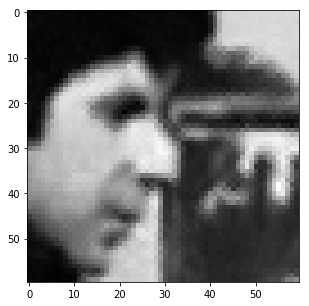

In [36]:
show(get_inset(improved_prediction))